In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Reshape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle


In [12]:
data = pd.read_csv('creditcard.csv')


In [13]:
# Split features and labels
X = data.drop(columns=['Class'])
y = data['Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN and LSTM input
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
X_reshaped.shape

(284807, 30, 1)

In [14]:
from sklearn.feature_selection import VarianceThreshold

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
X_high_variance = selector.fit_transform(X)
print("Original features:", X.shape[1])
print("Features after removing low variance:", X_high_variance.shape[1])

Original features: 30
Features after removing low variance: 30


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Define hybrid CNN-LSTM model
inputs = Input(shape=(X_train.shape[1], 1))  # Without batch_shape
print(X_train.shape[1])

# CNN part
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool1D(pool_size=2)(x)



# LSTM part
x = LSTM(64, return_sequences=True)(x)
x = LSTM(32)(x)

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
dense = Dense(32, activation='relu')(x)
dense = Dropout(0.5)(dense)
outputs = Dense(1, activation='sigmoid')(dense)
outputs

30


<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_42>

In [17]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 96s 13ms/step - accuracy: 0.9980 - loss: 0.0154 - val_accuracy: 0.9990 - val_loss: 0.0039
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9990 - val_loss: 0.0042
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 139s 19ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9991 - val_loss: 0.0040
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 207s 29ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9994 - val_loss: 0.0035
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 109s 15ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9993 - val_loss: 0.0047
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 127s 10ms/step - accuracy: 0.99

In [28]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [29]:
plot_learningCurve(x,10)

AttributeError: 'KerasTensor' object has no attribute 'history'

In [19]:
from sklearn.metrics import accuracy_score

# Assuming model.predict(X_test) returns probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Accuracy: 0.9994


In [20]:
with open('cnn_lstm_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the scaler used for feature scaling
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


In [21]:
model.save('cnn_lstm_model.h5', save_format='h5')

In [22]:
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

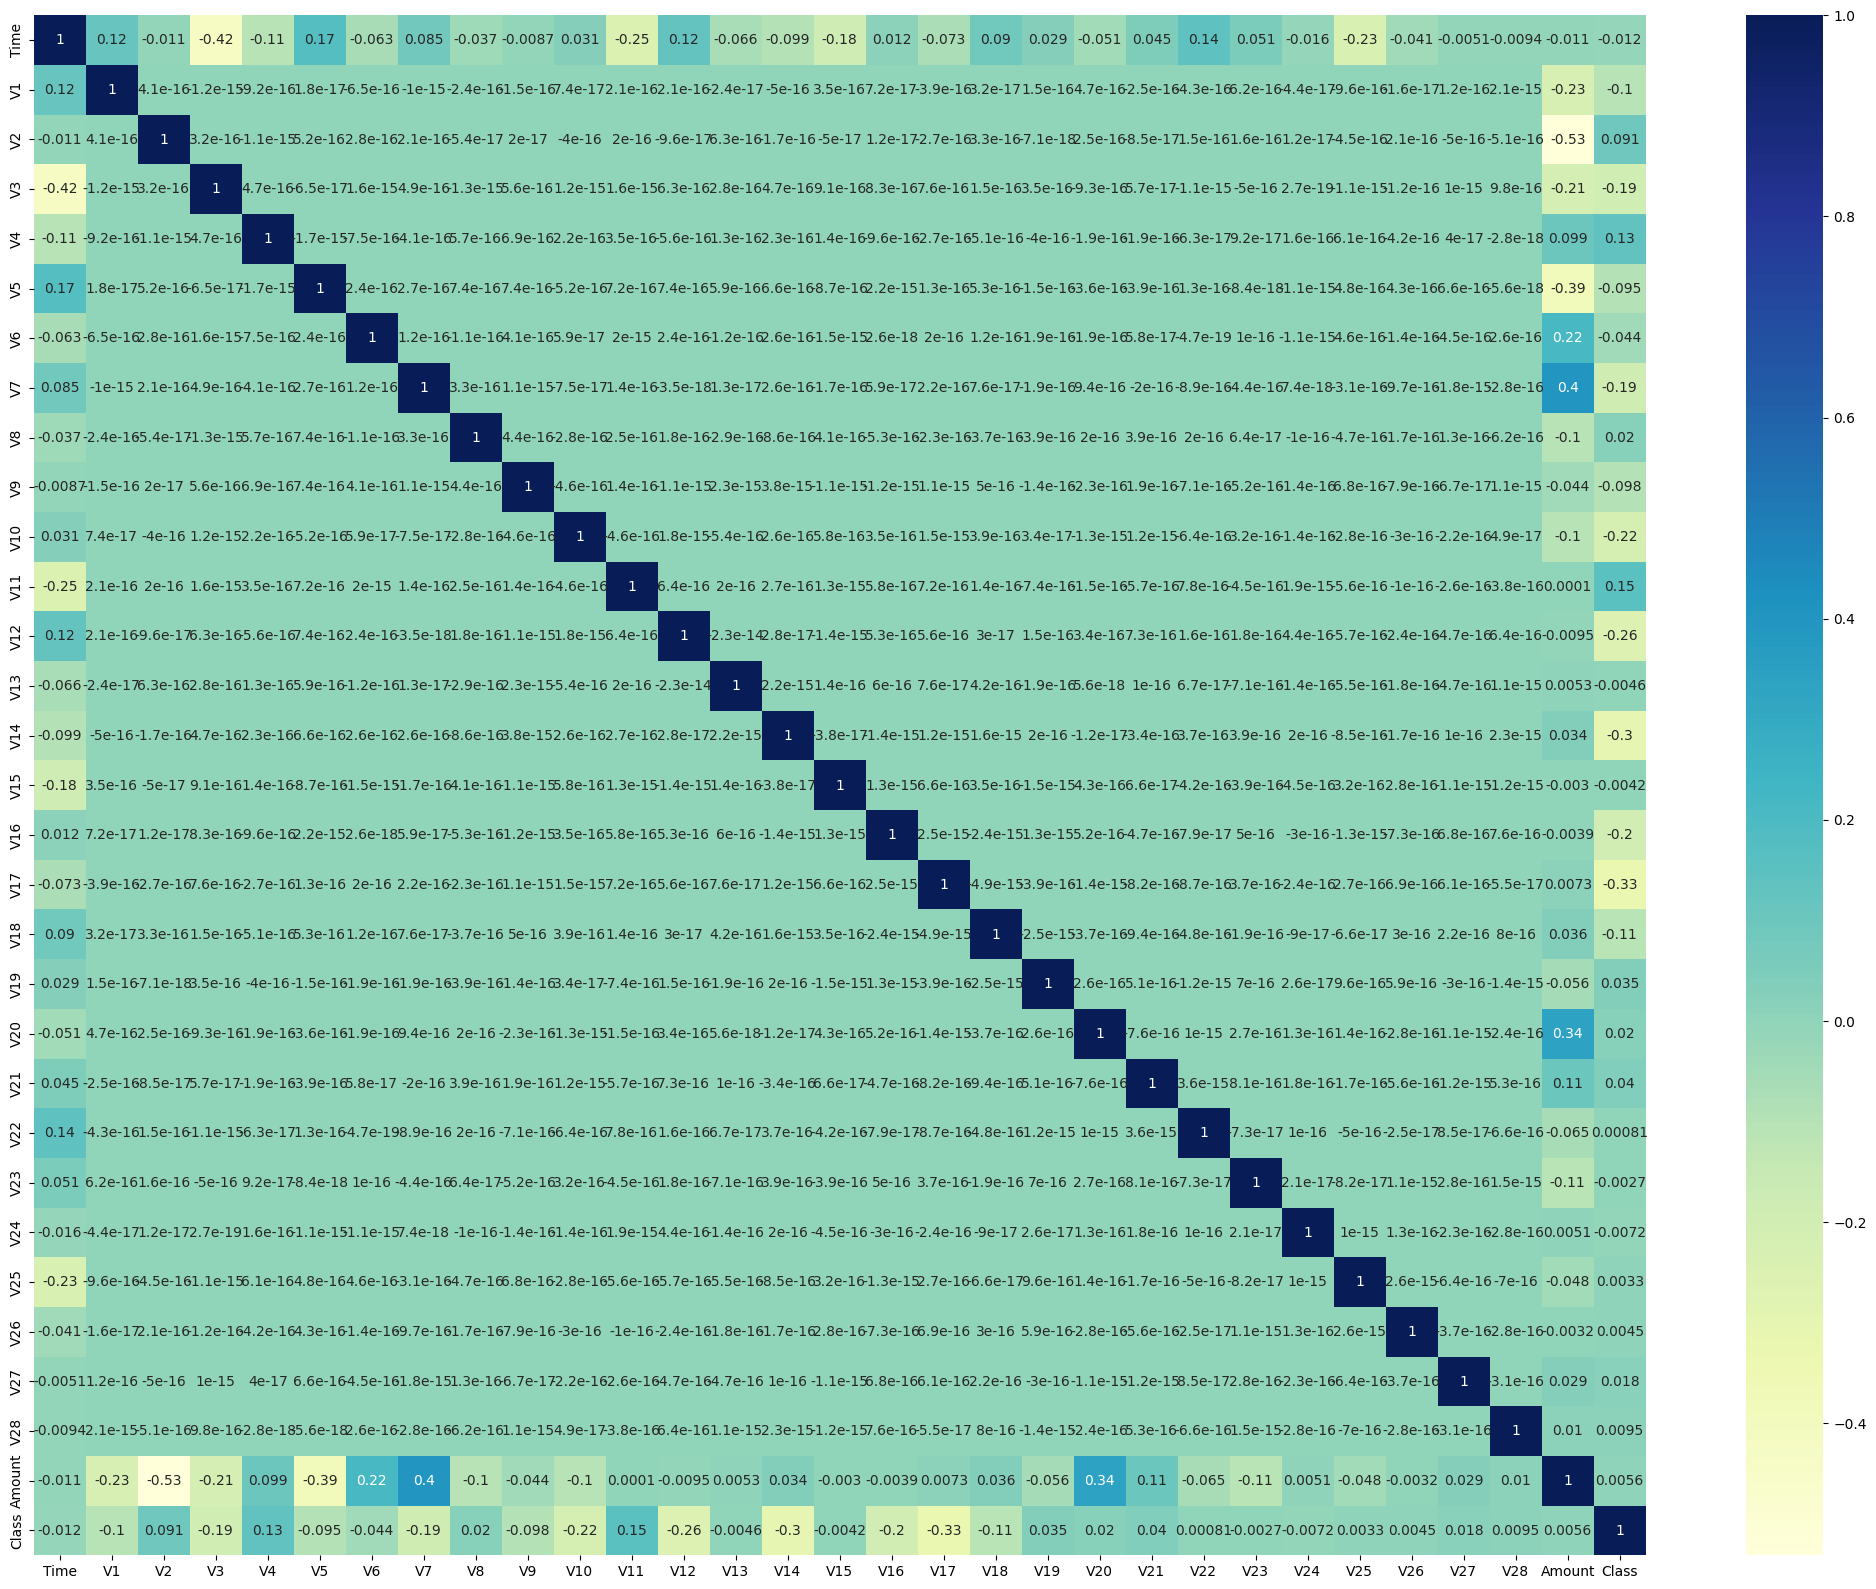

In [23]:
import seaborn as sns
data = pd.read_csv('creditcard.csv')
# Calculate correlation matrix
corr = data.corr()

plt.figure(figsize=(26,20))

sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def preprocess_data(data):
    """
    Comprehensive data preprocessing for fraud detection
    """
    # Use RobustScaler to handle outliers
    amount_scaler = RobustScaler()
    time_scaler = StandardScaler()
    
    # Scale features
    data['Amount'] = amount_scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
    data['Time'] = time_scaler.fit_transform(data['Time'].values.reshape(-1, 1))
    
    # Handle class imbalance with class weights
    fraud_count = data[data['Class'] == 1].shape[0]
    non_fraud_count = data[data['Class'] == 0].shape[0]
    class_weight = {0: 1, 1: non_fraud_count / fraud_count}
    
    return data, class_weight

def create_hybrid_model(input_shape, dropout_rate=0.3, l2_lambda=0.001):
    """
    Create a hybrid CNN-LSTM model with regularization techniques
    """
    model = Sequential([
        # Input layer with explicit input shape
        Input(shape=input_shape),
        
        # CNN Layers
        Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=l2(l2_lambda),
            input_shape=input_shape
        ),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        
        Conv1D(
            filters=128, 
            kernel_size=3, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=l2(l2_lambda)
        ),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        
        # Flatten or LSTM
        Flatten(),
        
        # Dense Layers
        Dense(
            128, 
            activation='relu', 
            kernel_regularizer=l2(l2_lambda)
        ),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(
            64, 
            activation='relu', 
            kernel_regularizer=l2(l2_lambda)
        ),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy', 
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

def train_model(X_train, y_train, X_test, y_test, class_weight):
    """
    Train the model with advanced callbacks
    """
    # Reshape input for CNN (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Callbacks to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )
    
    # Create and train model
    model = create_hybrid_model(
        input_shape=(X_train.shape[1], 1), 
        dropout_rate=0.3, 
        l2_lambda=0.0001
    )
    
    history = model.fit(
        X_train, y_train, 
        epochs=50, 
        batch_size=64, 
        validation_data=(X_test, y_test),
        class_weight=class_weight,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    model.save('new.h5')
    return model, history

def evaluate_model(model, X_test, y_test):
    """
    Comprehensive model evaluation
    """
    # Reshape test data
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Predictions
    y_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)
    
    # Detailed Evaluation
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nROC AUC Score:")
    print(roc_auc_score(y_test, model.predict(X_test_reshaped)))

def main():
    # Load dataset
    data = pd.read_csv('creditcard.csv')
    
    # Preprocess data
    data, class_weight = preprocess_data(data)
    
    # Split features and target
    X = data.drop('Class', axis=1).values
    y = data['Class'].values
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    # Train model
    model, history = train_model(X_train, y_train, X_test, y_test, class_weight)
    
    # Evaluate model
    evaluate_model(model, X_test, y_test)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



Epoch 1/50


c:\Users\prane\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3561/3561 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.7839 - auc_4: 0.9003 - loss: 0.8916 - val_accuracy: 0.9645 - val_auc_4: 0.9623 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 2/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9239 - auc_4: 0.9499 - loss: 0.6110 - val_accuracy: 0.9726 - val_auc_4: 0.9582 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 3/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9415 - auc_4: 0.9623 - loss: 0.5384 - val_accuracy: 0.9773 - val_auc_4: 0.9741 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 4/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9507 - auc_4: 0.9652 - loss: 0.5122 - val_accuracy: 0.9701 - val_auc_4: 0.9774 - val_loss: 0.2527 - learning_rate: 0.0010
Epoch 5/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9622 - auc_4: 0.9848 - loss: 0.3897 - val_accuracy: 0.9771 - val_auc_4: 0.9702 - val_loss: 0.2480 - learning_rate: 0.0010
Epoch 6/50
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


Confusion Matrix:
[[55312  1552]
 [    9    89]]

ROC AUC Score:
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
0.9585113747947125


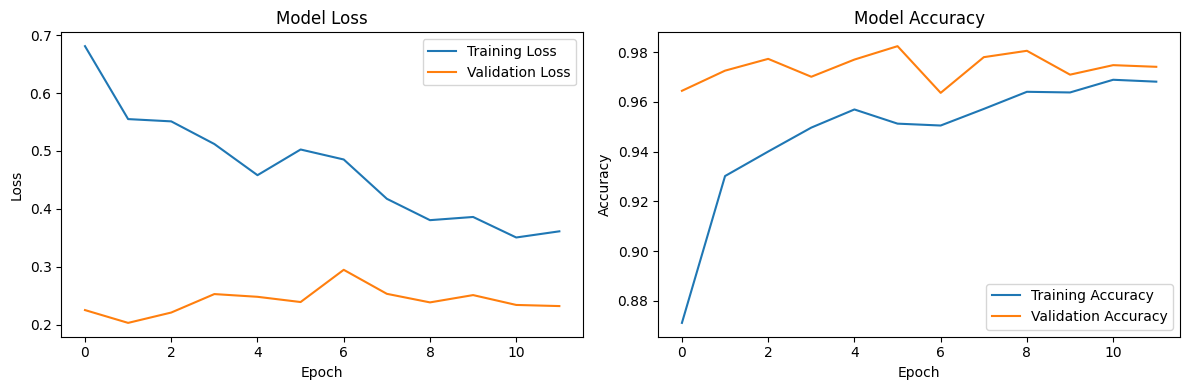

In [42]:
main()

In [1]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('new.h5')
# summarize model.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,635 (584.52 KB)

 Trainable params: 148,865 (581.50 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2 (12.00 B)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model

# Load data
data = pd.read_csv('creditcard.csv')

# Scale 'Amount' and 'Time'
data['Amount'] = RobustScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))

# Split features and target
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Reshape for model input (samples, timesteps, features)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [3]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('new.h5')


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


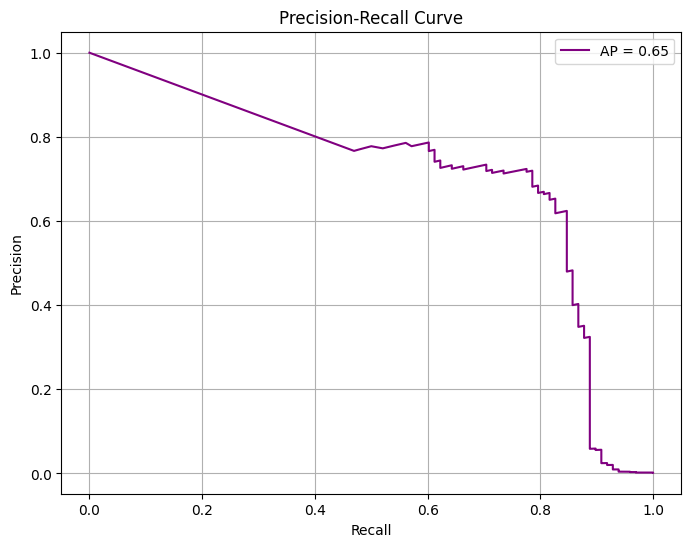

In [4]:
# Get predicted probabilities (not classes)
y_pred_proba = model.predict(X_test)
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap_score = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


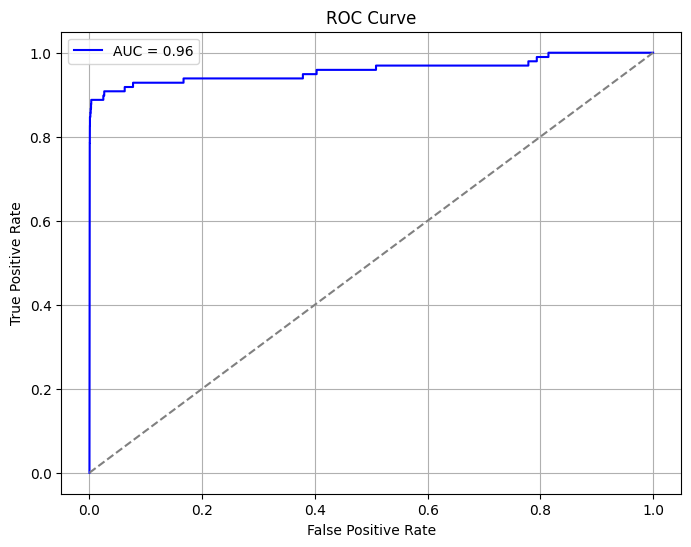

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [3]:
# Load trained model
model = load_model('new.h5')
model.summary()

# Predict (threshold 0.5)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,635 (584.52 KB)

 Trainable params: 148,865 (581.50 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2 (12.00 B)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [4]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# ROC AUC Score
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


Confusion Matrix:
 [[55312  1552]
 [    9    89]]

ROC AUC Score: 0.9585113747947125


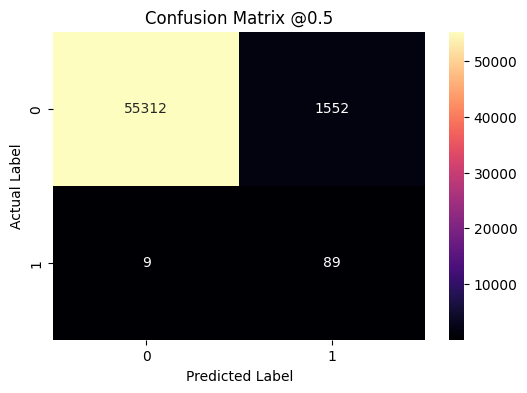

In [5]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title('Confusion Matrix @0.5')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


In [6]:
def plot_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix @0.5')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()


In [5]:
def plot_model_comparison():
    models = ['CNN-LSTM', 'CNN', 'LSTM']
    accuracy = [0.97, 0.92,0.991166]  # <-- Replace with your actual test results
    f1_score = [0.99,0.81,0.91]

    x = np.arange(len(models))
    width = 0.3

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, accuracy, width, label='Accuracy')
    plt.bar(x + width/2, f1_score, width, label='Recall')

    plt.xticks(x, models)
    plt.ylim(0.7, 1.0)
    plt.ylabel('Score')
    plt.title('Model Comparison: Accuracy vs Recall')
    plt.legend()
    plt.grid(True)
    plt.show()


In [33]:
def plot_hexbin_distribution(data):
    fraud = data[data['Class'] == 1]
    non_fraud = data[data['Class'] == 0]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hexbin(fraud['V5'], fraud['V6'], gridsize=30, cmap='Blues', mincnt=1)
    plt.title('Positive (Fraud) Distribution')
    plt.xlabel('V5')
    plt.ylabel('V6')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.hexbin(non_fraud['V5'], non_fraud['V6'], gridsize=30, cmap='Purples', mincnt=1)
    plt.title('Negative (Non-Fraud) Distribution')
    plt.xlabel('V5')
    plt.ylabel('V6')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [34]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [35]:
def plot_case_amount_stats(data):
    stats = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    fraud = data[data['Class'] == 1]['Amount'].describe()[stats]
    non_fraud = data[data['Class'] == 0]['Amount'].describe()[stats]

    df = pd.DataFrame({
        'Fraud': fraud,
        'Non-Fraud': non_fraud
    })

    df.plot(kind='line', marker='o', figsize=(10, 5))
    plt.title('Case Amount Statistics for Fraud and Non-Fraud')
    plt.ylabel('Amount')
    plt.grid(True)
    plt.show()


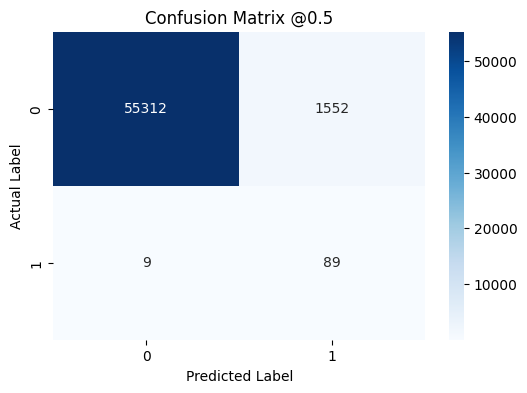

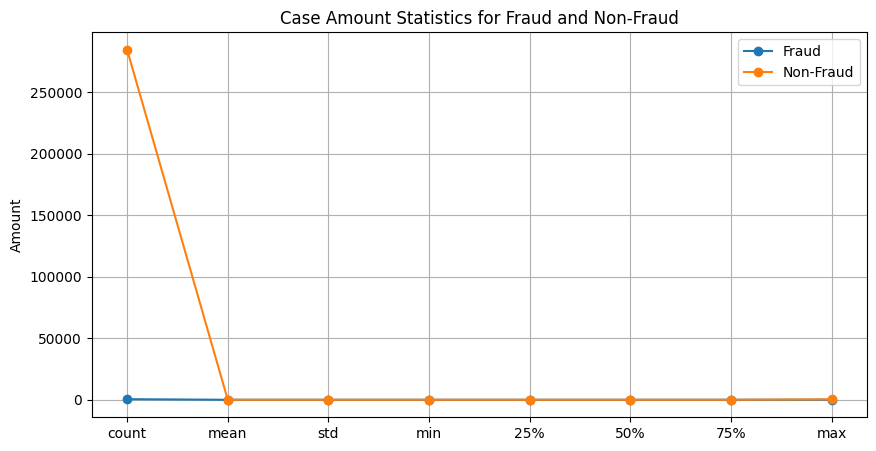

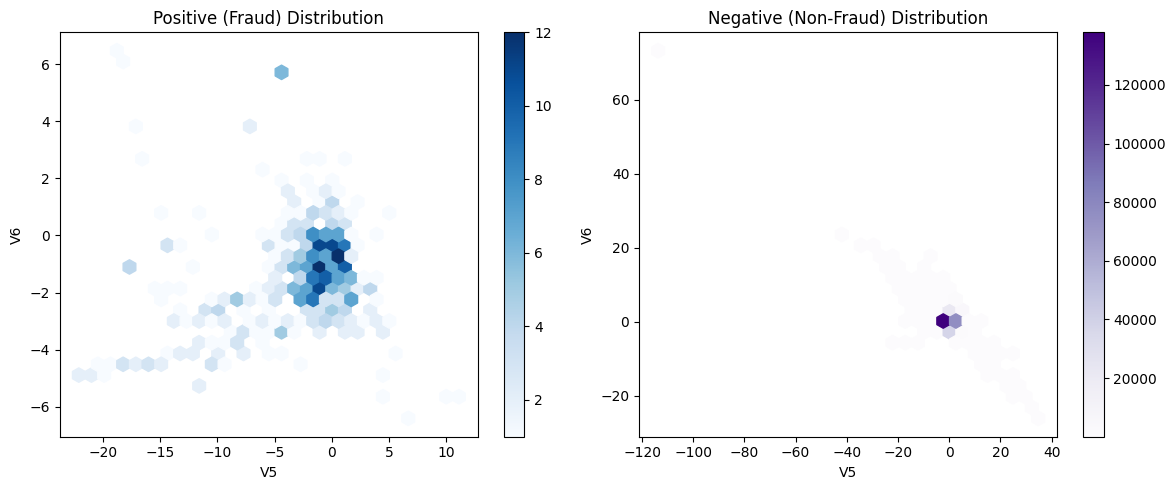

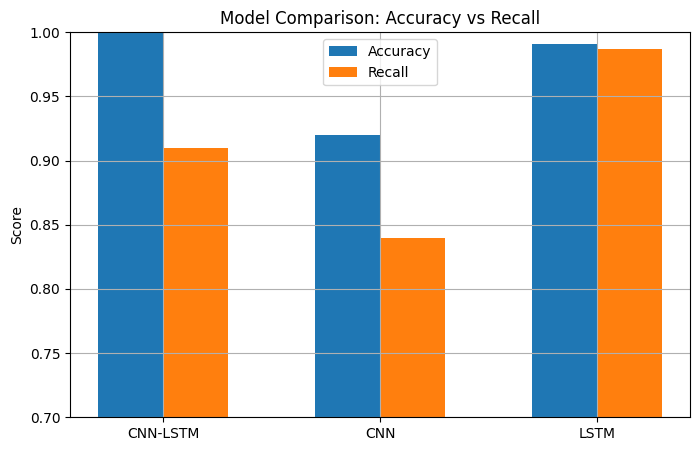

In [36]:
plot_confusion_matrix(y_test, y_pred)
plot_case_amount_stats(data)
plot_hexbin_distribution(data)
plot_model_comparison()  # if you have more than one model


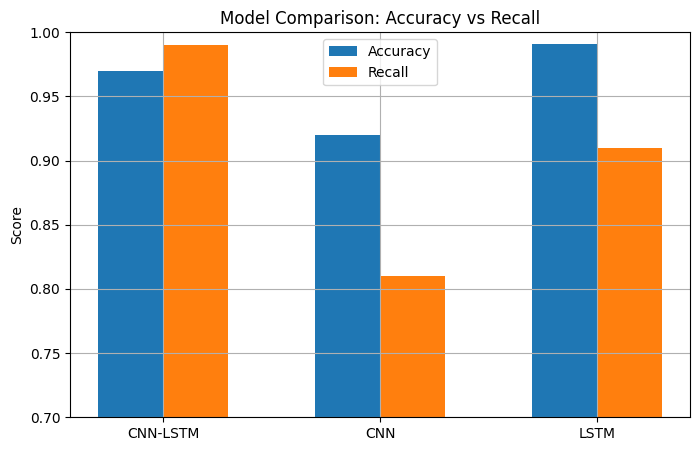

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plot_model_comparison()

c:\Users\prane\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


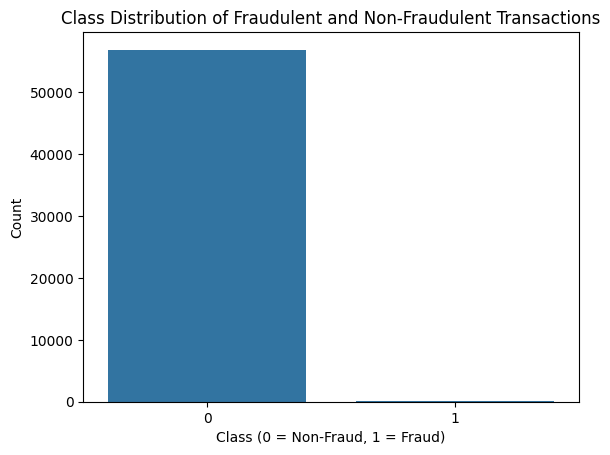

In [11]:
# Load models
import joblib
cnn_model = joblib.load('CNN_model.pkl')
lstm_model = joblib.load('LSTM_model.pkl')

# Load h5 hybrid model
cnn_lstm_model = load_model('new.h5') # your cnn-lstm

# Evaluate models
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_test)
plt.title("Class Distribution of Fraudulent and Non-Fraudulent Transactions")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()



1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


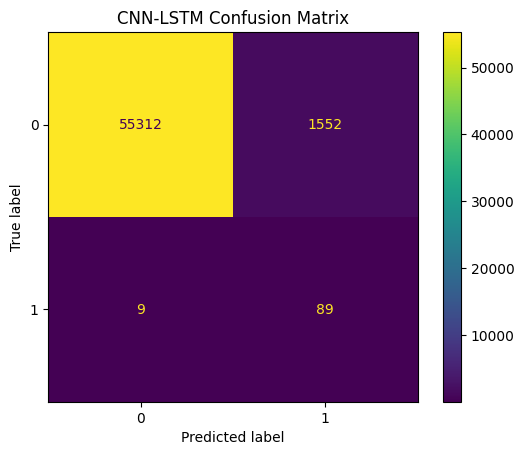

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


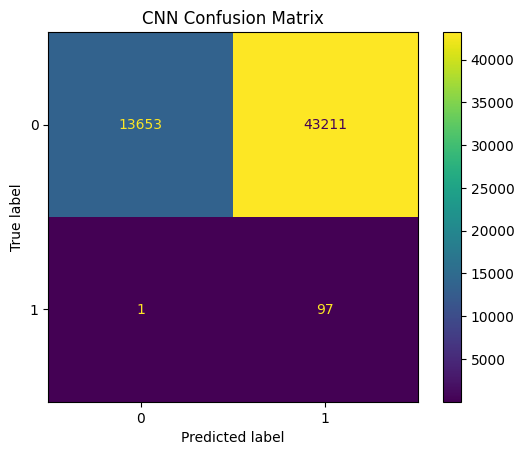

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


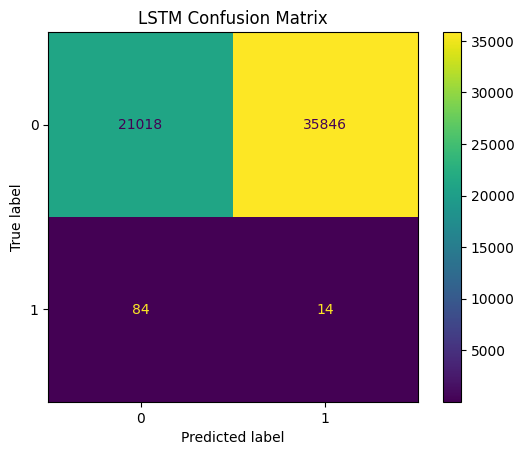

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_conf_matrix(model, X_test, y_test, title="Confusion Matrix", keras=False, already_reshaped=False):
    if keras:
        if not already_reshaped:
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        if hasattr(model, "predict_proba"):
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

X_test_lstm = X_test[:, :9]  # or the exact 9 features used during training
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, 9))  # shape: (batch, timesteps, features)
plot_conf_matrix(cnn_lstm_model, X_test, y_test, title="CNN-LSTM Confusion Matrix", keras=True)
plot_conf_matrix(cnn_model, X_test, y_test, title="CNN Confusion Matrix")
plot_conf_matrix(lstm_model, X_test_lstm, y_test, title="LSTM Confusion Matrix", keras=True, already_reshaped=True)



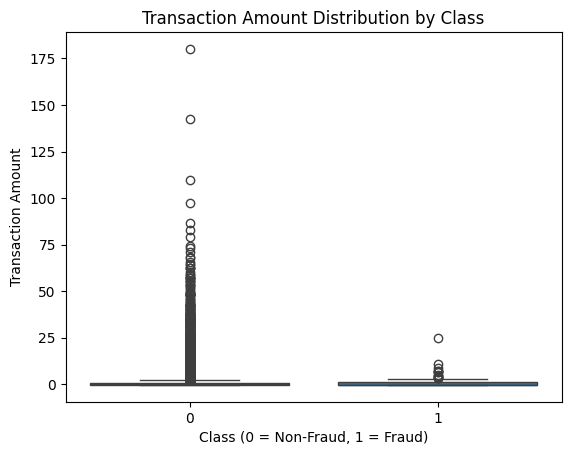

In [16]:
import pandas as pd

df = pd.DataFrame({
    "Class": y_test.ravel(),
    "Amount": X_test[:, -1].ravel()
})

sns.boxplot(x="Class", y="Amount", data=df)
plt.title("Transaction Amount Distribution by Class")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


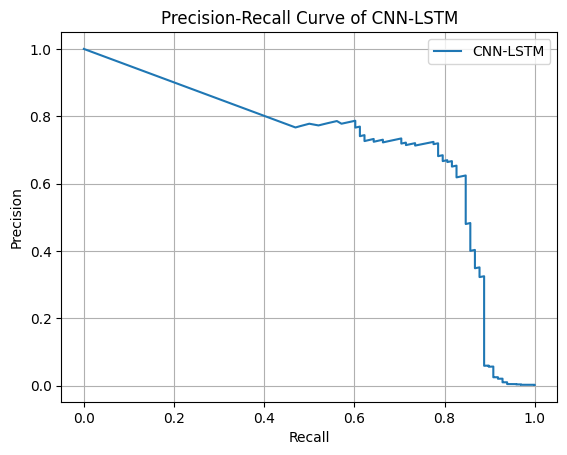

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


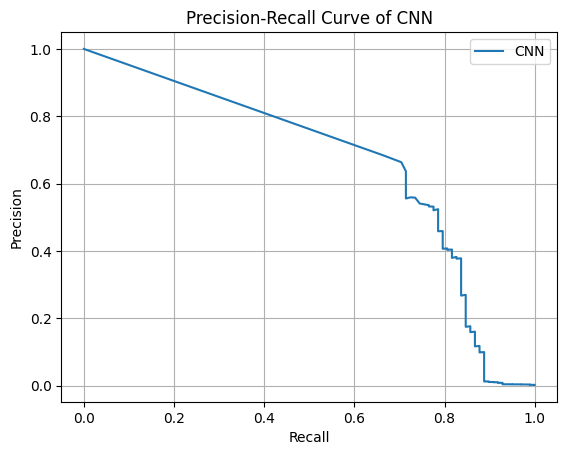

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


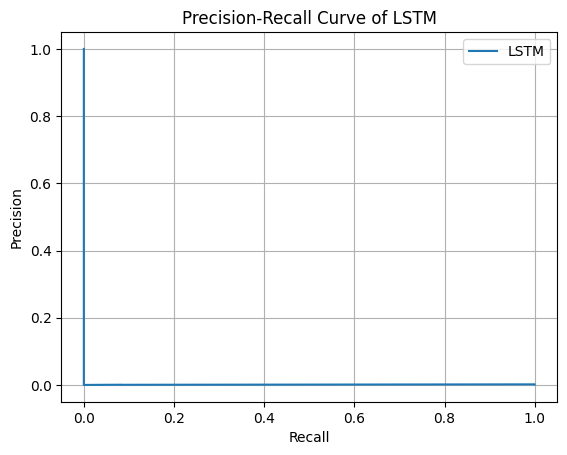

In [27]:
from sklearn.metrics import precision_recall_curve
hybrid_model = load_model('new.h5')
X_test_lstm = X_test[:, :9]  # or the exact 9 features used during training
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, 9))  # shape: (batch, timesteps, features)


def plot_pr_curve(y_true, y_prob, label="Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f'Precision-Recall Curve of {label}')
    plt.legend()
    plt.grid(True)

# Example
plot_pr_curve(y_test, hybrid_model.predict(X_test).flatten(), "CNN-LSTM")
plt.show()
plot_pr_curve(y_test, cnn_model.predict(X_test).flatten(), "CNN")
plt.show()
plot_pr_curve(y_test, lstm_model.predict(X_test_lstm).flatten(), "LSTM")
plt.show()


In [37]:
!pip install pydot graphviz



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load your hybrid CNN-LSTM model
model = load_model('new.h5')

# Plot the architecture to a PNG file
plot_model(model, to_file='archi.png', show_shapes=True, show_layer_names=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [4]:
from IPython.display import Image
Image(filename='archi.png')


FileNotFoundError: [Errno 2] No such file or directory: 'archi.png'